## Hybrid modleing approach: _**Physics-Informed Neural Networks**_ (PINN) 

In this example, we are going to consider a situation, when some experimental data is observed, and we fit a NN to the data:

- First, without any additional information.
- Second, with the information about the nature of the data included in the fitting process.

The observations are collectd from a [Damped Harmonic Oscillator](https://beltoforion.de/en/harmonic_oscillator/) system, which describes the movement of a mechanical oscillator (e.g., _spring pendulum_) under the influence of a restoring force and friction.

It can be modelled by the following _ordinary differential equation_ (ODE):

$$
\frac{d^2}{dt^2}x(t)+\frac{\mu}{m}\frac{d}{dt}x(t)+\frac{k}{m}x(t) = 0,
$$

which is a _**second-order ODE**_. Here,

- $m$ is a _**mass**_ attached to a spring.
- $\mu$ is a material and shape dependent _**coefficient of friction**_.
- $k$ is a material dependent _**spring constant**_.
- $x(t)$ represents the position of the mass at time $t$.

To find a unique solution of the ODE, one needs to know
- $x_0$ -- an initial position of a mass.
- $v_0$ -- an initial velocity.

Let $\delta = \frac{\mu}{2m}$ and $\omega_0 = \sqrt{\frac{k}{\mu}}$. 

If $\delta < \omega_0$, then the solution of the ODE is given by

$$
x(t) = 2Ae^{-\delta t}\cos\left(\phi+\omega t\right), \: \omega = \sqrt{\omega_0^2-\delta^2},
$$

and constants $A$ and $\phi$ are defined from the initial conditions:

$$
\left\{\begin{aligned}
x(0) &= x_0 \\
\frac{d}{dt}x(0) &= v_0
\end{aligned}\right. \Rightarrow 
\left\{\begin{aligned}
\phi &= \arctan\left(-\frac{\delta}{\omega}\right)\\
A &= \frac{1}{2\cos{(\phi)}}
\end{aligned}\right.
$$

Let's start from loading necessary modules. 

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

Now, let's create a function, representing the ODE solution.

In [25]:
def oscillator(delta, omega0, t):
    assert delta < omega0

    # calculating omega parameter
    omega = np.sqrt(omega0 ** 2 - delta ** 2)

    # parameter phi
    phi = np.arctan(-delta/omega)

    # parameter A
    A = 0.5 / np.cos(phi)

    # writing down the ODE solution
    x = 2 * A * torch.exp(-delta * t)*torch.cos(phi + omega * t)
    
    return x

We simulate observations from the system by using an ODE solution given above, setting the parameters' values to $\delta=2$, $\omega_0 = 20$. 

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([500, 1]) torch.Size([500, 1])


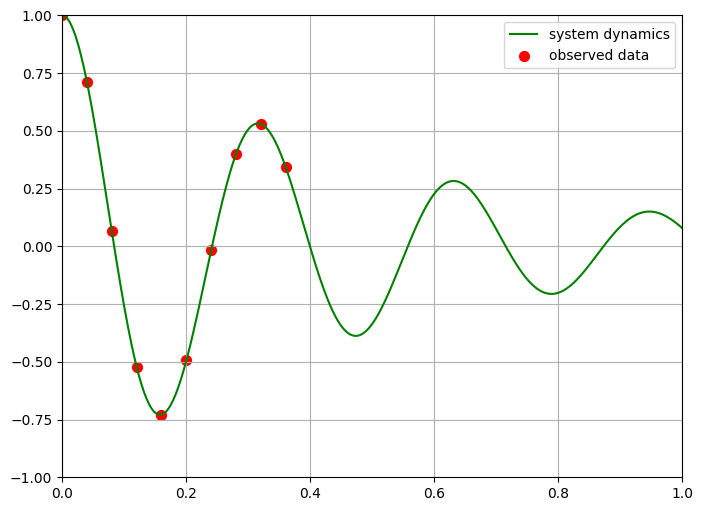

In [26]:
# a true dynamics over [0, 1] time period
delta, omega0 = 2, 20
t = torch.linspace(0, 1, 500).view(-1, 1)
x = oscillator(delta, omega0, t).view(-1, 1)
print(t.shape, x.shape)

# collected observations
t_obs = t[0:200:20]
x_obs = x[0:200:20]

# visualizing simulated data
plt.figure(figsize = (8, 6))
plt.plot(t, x, color="green", label="system dynamics")
plt.scatter(t_obs, x_obs, color="red", s = 50, label="observed data")
plt.grid()
plt.xlim((0, 1))
plt.ylim((-1, 1))
plt.legend(loc = "upper right")
plt.savefig("figures/lecture01-ex03a.png", dpi = 300)

Now, given nine observations from the system (_red dots_ on the plot), let's fit the observation data by a _neural network_. We are going to use _torch_ module.

In [27]:
class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, n_input, n_output, n_hidden, n_layers):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[nn.Linear(n_input, n_hidden), activation()])
        self.fch = nn.Sequential(
            *[nn.Sequential(
                *[nn.Linear(n_hidden, n_hidden), activation()]) for _ in range(n_layers-1)
            ])
        self.fce = nn.Linear(n_hidden, n_output)
        
    def forward(self, t):
        t = self.fcs(t)
        t = self.fch(t)
        x = self.fce(t)
        return x

Now, let's train our NN-based model.

In [28]:
torch.manual_seed(123)
model = FCN(1, 1, 32, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for i in range(1000):
    optimizer.zero_grad()
    xh = model(t_obs)
    loss = torch.mean((xh-x_obs)**2) # MSE loss
    loss.backward()
    optimizer.step()

Visualizing results.

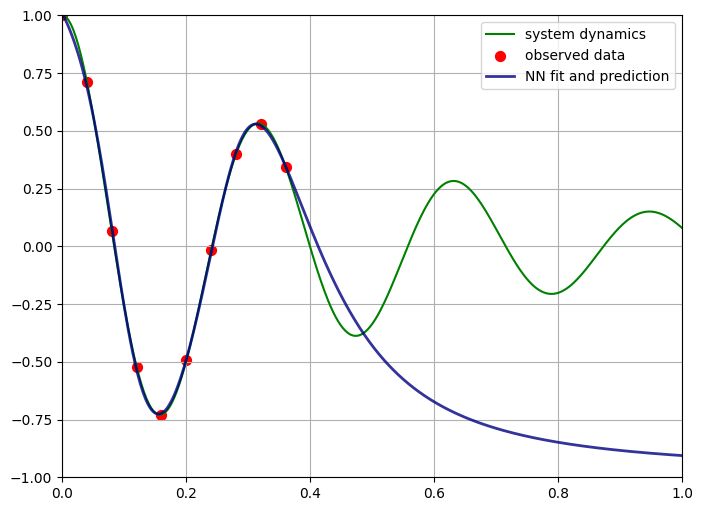

In [29]:
plt.figure(figsize = (8, 6))
plt.plot(t, x, color="green", label="system dynamics")
plt.scatter(t_obs, x_obs, color="red", s = 50, label="observed data")
plt.plot(t, model(t).detach(), color="navy", linewidth=2, alpha=0.8, label="NN fit and prediction")
plt.grid()
plt.xlim((0, 1))
plt.ylim((-1, 1))
plt.legend(loc = "upper right")
plt.savefig("figures/lecture01-ex03b.png", dpi = 300)

As we can see, the NN approximation does a great job by fittin NN to the observed data. However, it fails to make a prediction outside the observed range.

Let's try to fix the situation by using the fact that observations a collected from the physical system, which follows the _**phsysical law**_ described by the second-order ODE.

So, when we approximate $x(t)$ by $NN(t)$, we have to use the information about the nature of the data, i.e., $NN(t)$ must satisfy the ODE as well. 

Thus, we use a second loss function, given by

$$
\left(\frac{d^2}{dt^2}NN(t)+\frac{\mu}{m}\frac{d}{dt}NN(t)+\frac{k}{m}NN(t)\right)^2.
$$

In [33]:
mu, k = 2*delta, omega0**2
# sample locations over the problem domain
t_p = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)

torch.manual_seed(123)
model = FCN(1, 1, 32, 3)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

for i in range(20000):
    optimizer.zero_grad()
    
    # compute the "data loss"
    xh = model(t_obs)
    loss1 = torch.mean((xh - x_obs) **2 )
    
    # compute the "physics loss"
    xhp = model(t_p)

    # first derivative of NN(t)
    dotx  = torch.autograd.grad(xhp, t_p, torch.ones_like(xhp), create_graph=True)[0]
    
    # second derivative of NN(t)
    ddotx = torch.autograd.grad(dotx, t_p, torch.ones_like(dotx), create_graph=True)[0]
    
    # computes the residual of the second-order ODE
    physics = ddotx + mu * dotx + k * xhp
    loss2 = (1e-4) * torch.mean(physics ** 2)
    
    # backpropagate joint loss
    loss = loss1 + loss2
    loss.backward()
    optimizer.step()

Visualizing results.

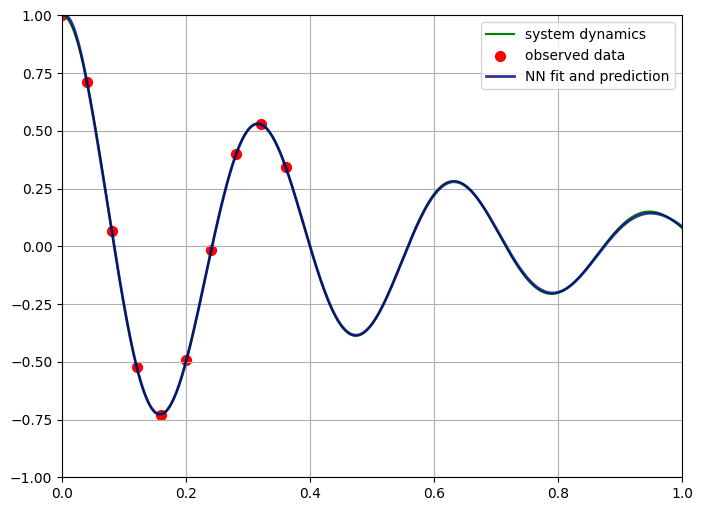

In [34]:
plt.figure(figsize = (8, 6))
plt.plot(t, x, color="green", label="system dynamics")
plt.scatter(t_obs.detach(), x_obs, color="red", s = 50, label="observed data")
plt.plot(t, model(t).detach(), color="navy", linewidth=2, alpha=0.8, label="NN fit and prediction")
plt.grid()
plt.xlim((0, 1))
plt.ylim((-1, 1))
plt.legend(loc = "upper right")
plt.savefig("figures/lecture01-ex03b.png", dpi = 300)